# Lesson 2: Centralized LLM Fine-tuning

Welcome to Lesson 2!

To access the `requirements.txt` and `utils` files for this course, go to `File` and click `Open`.

#### 1. Import packages and utilities

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from utils.utils import *
from utils.LLM import LLM_pretrained, LLM_cen_partial
from utils.LLM import get_fireworks_api_key,load_env

/usr/local/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


> Note: Throughout this course, we use Hydra, a framework for managing and configuring files. 

In [2]:
# Load config
cfg = get_config("centralized")

# Inspect the config
print_config(cfg)

dataset:
  name: medalpaca/medical_meadow_medical_flashcards
model:
  name: EleutherAI/pythia-70m
  quantization: 4
  gradient_checkpointing: true
  use_fast_tokenizer: true
  lora:
    peft_lora_r: 16
    peft_lora_alpha: 64
    target_modules: null
train:
  save_every_round: 5
  seq_length: 512
  padding_side: left
  training_arguments:
    learning_rate: 0.0005
    per_device_train_batch_size: 2
    gradient_accumulation_steps: 1
    logging_steps: 1
    max_steps: 5
    report_to: null
    save_steps: 200
    save_total_limit: 10
    gradient_checkpointing: true
    lr_scheduler_type: cosine



#### 2. Load the dataset
  
**Note:** For more information about the dataset, check here [medAlpaca](https://arxiv.org/abs/2304.08247).

In [3]:
trainset_full = load_dataset(cfg.dataset.name, split='train')
train_test = trainset_full.train_test_split(test_size=0.9, seed=1234)
train_dataset = train_test["train"]

train_dataset = format_dataset(train_dataset)

print(train_dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['response', 'instruction'],
    num_rows: 3395
})


In [4]:
# Print an example from the dataset
example_index = 9

data_point = train_dataset[example_index]

data_point

{'response': 'The IVC perforates the diaphragm at the level of T8.',
 'instruction': 'At what level does the inferior vena cava (IVC) perforate the diaphragm?'}

#### 3. Asking the LLM 


* First attempt 

Ask a pre-trained LLM a question in a specific domain.

In [5]:
llm_pretrained = LLM_pretrained()

* Write a prompt to ask the LLM.

In [6]:
prompt = "How to predict the weather"
llm_pretrained.eval(prompt, verbose = False)
llm_pretrained.print_response(verbose = False)

?  The weather is a very important factor in our
	lives. It can affect our mood, our health, and
	even our productivity. That’s why it’s important
	to know how to predict the weather.  There are a
	few different ways to predict the weather. One
	way is to look at the sky. If the sky is clear,
	then the weather is likely to be good


* Evaluate pre-trained model on Medical Q&A

In [7]:
llm_pretrained.eval(data_point['instruction'], verbose=True)

llm_pretrained.print_response()

ex_response = format_string(data_point['response'])
print(f"Expected output:\n\t{ex_response}")

Prompt:
	At what level does the inferior vena cava (IVC)
	perforate the diaphragm?
Response:
	The inferior vena cava (IVC) perforates the
	diaphragm at the level of the 12th thoracic
	vertebra.  The IVC is a large vein that returns
	blood from the lower half of the body to the
	heart. It begins at the confluence of the common
	iliac veins and ends at the
Expected output:
	The IVC perforates the diaphragm at the level of
	T8.


* Second attempt:

Ask a fine tuned LLM a question in a specific domain.

* Set the model.

In [8]:
model = get_model(cfg.model)


trainable, all_parameters = model.get_nb_trainable_parameters()
print(f"Trainable parameters: {trainable}")
print(f"All parameters: {all_parameters}")
print(f"Trainable (%): {100*trainable / all_parameters:.3f}")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

Trainable parameters: 196608
All parameters: 70623232
Trainable (%): 0.278


* Define the tokenizer.

In [9]:
(
tokenizer, 
data_collator, 
format_prompts_fn
) = get_tokenizer_and_data_collator_and_propt_formatting(
        cfg.model.name, cfg.model.use_fast_tokenizer, cfg.train.padding_side
)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


* Define the finetune_centralised function.

In [10]:
save_centralized = "./my_centralized_model"
def finetune_centralised():

    # The notebooks you are running in this course does not
    # come with a GPU. However, we don't harcode "cpu" as the
    # device to use in case you wish to download this notebook
    # and run it on your own GPU.
    use_cuda = torch.cuda.is_available()
    training_arguments = TrainingArguments(
                         **cfg.train.training_arguments,
                         use_cpu=not(use_cuda),
                         output_dir=save_centralized,
    )

    # Construct trainer
    trainer = SFTTrainer(
        tokenizer=tokenizer,
        data_collator=data_collator,
        formatting_func=format_prompts_fn,
        max_seq_length=cfg.train.seq_length,
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
    )

    # Do local training
    trainer.train()

    # Save the checkpoint
    model.save_pretrained(save_centralized)

* Let's do some fine-tuning.

In [11]:
finetune_centralised()

Map:   0%|          | 0/3395 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
1,4.500000
2,3.421900
3,4.437500
4,3.687500
5,3.921900


> Note: The previous fine-tuning was performed on a smaller model. To fine-tune a larger model (e.g., a 7 billion parameter model), you can use the same code with a different configuration. Refer to the code snippet below:


```
 cfg = get_config("centralized_full")
```

It is recommended to execute all prior cells with this configuration. However, please ensure that your machine has at least one GPU.

* Evaluate the Centrally fine-tuned LLM.

In [12]:
llm_cen = LLM_cen_partial()
example_index = 9

data_point = train_dataset[example_index]

llm_cen.eval(data_point['instruction'], verbose=True)

llm_cen.print_response()

ex_response = format_string(data_point['response'])
print(f"Expected output:\n\t{ex_response}")

Prompt:
	At what level does the inferior vena cava (IVC)
	perforate the diaphragm?
Response:
	The IVC perforates the diaphragm at the level of
	the T8 vertebra. The IVC is a large blood vessel
	that carries deoxygenated blood from the lower
	part of the body back to the heart. It begins at
	the junction of the right and left common iliac
	veins and runs upward along the right side of the
	abdomen, passing
Expected output:
	The IVC perforates the diaphragm at the level of
	T8.


#### 4. Visualize results of prompting with pretrained LLM and fine-tuned LLM

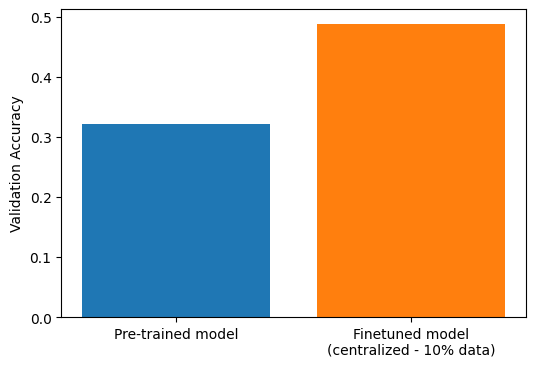

In [13]:
visualize_results(results=['7b/pretrained', '7b/cen_10'])

#### Extra! 

#### Generate the data structure for systematic evaluation

We used this code to evaluate the performance of the finetuned 7B LLM you tested in the previous code cell.

In [14]:
# Lauch evalution code
# from utils.utils import inference, evaluate

# Step 1: generate answers
# To run inference on the pre-trained model:
# inference(base_model_name_path=cfg.model.name, run_name="pretrained")

# To run inference on the centralised finetuned model:
# inference(
#           base_model_name_path=cfg.model.name, 
#           peft_path=path/to/your/checkpoint/directory, 
#           run_name="centralised_finetuned",
# )


# Step 2: evaluation --- accuracy value will be printed
# evaluate(run_name="pretrained")
# evaluate(run_name="centralised_finetuned")